# Загрузка и базовая подготовка



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '/content/drive/MyDrive/diplom/Surgut_final_data/Surgut_data_2019_to_2024_COMBINED.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
# Конвертируем колонку 'date' в правильный формат
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Выводим базовую информацию и проверяем пропуски ДО обработки
print("--- ИНФОРМАЦИЯ О СЫРЫХ ДАННЫХ ---")
df.info()
print("\nКоличество пропусков ДО обработки:")
print(df.isna().sum())

--- ИНФОРМАЦИЯ О СЫРЫХ ДАННЫХ ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1454 non-null   datetime64[ns]
 1   city                 1454 non-null   object        
 2   no2_trop_mean        877 non-null    float64       
 3   cloud_frac_mean      1447 non-null   float64       
 4   temperature_celsius  1454 non-null   float64       
 5   pressure_hpa         1454 non-null   float64       
 6   u_wind_10m           1454 non-null   float64       
 7   v_wind_10m           1454 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 91.0+ KB

Количество пропусков ДО обработки:
date                     0
city                     0
no2_trop_mean          577
cloud_frac_mean          7
temperature_celsius      0
pressure_hpa             0
u_wind_10m          

In [6]:
count_all = df.shape[0]
nan_no2 = df['no2_trop_mean'].isna().sum()
print(f"Процент валидных данных: {(count_all - nan_no2) / count_all}")

Процент валидных данных: 0.6031636863823934


# Обработка пропусков (Интерполяция)

In [9]:
print("\n--- НАЧИНАЮ ОБРАБОТКУ ПРОПУСКОВ ---")

# Устанавливаем дату как индекс, чтобы интерполяция работала корректно по времени
df.set_index('date', inplace=True)




--- НАЧИНАЮ ОБРАБОТКУ ПРОПУСКОВ ---


# Создание новых признаков (Feature Engineering)

In [7]:
# --- УЛУЧШЕНИЕ ЧИТАЕМОСТИ И НОВЫЕ ПРИЗНАКИ ---
# Создаем новую колонку NO2 в мкмоль/м²
df['no2_umol_m2'] = df['no2_trop_mean'] * 1e6

In [10]:
print("\n--- СОЗДАЮ НОВЫЕ ПРИЗНАКИ ---")

# Временные признаки (помогают модели уловить сезонность и недельные циклы)
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek  # 0 = Понедельник, 6 = Воскресенье
df['week_of_year'] = df.index.isocalendar().week

# Физические признаки (более понятны для модели, чем компоненты u/v)
df['wind_speed'] = np.sqrt(df['u_wind_10m']**2 + df['v_wind_10m']**2)
df['wind_direction'] = (np.arctan2(df['u_wind_10m'], df['v_wind_10m']) * 180 / np.pi + 360) % 360

# Удаляем исходные компоненты ветра, т.к. мы их заменили
df.drop(['u_wind_10m', 'v_wind_10m'], axis=1, inplace=True)

print("Готово. Первые 5 строк с новыми признаками:")
print(df.head())


--- СОЗДАЮ НОВЫЕ ПРИЗНАКИ ---
Готово. Первые 5 строк с новыми признаками:
              city  no2_trop_mean  cloud_frac_mean  temperature_celsius  \
date                                                                      
2019-02-01  Surgut       0.000033         0.358617           -41.178692   
2019-02-02  Surgut       0.000033         0.234913           -36.925752   
2019-02-03  Surgut       0.000037         0.269149           -37.639476   
2019-02-04  Surgut       0.000030         0.371478           -30.934249   
2019-02-05  Surgut       0.000037         0.423403           -32.243940   

            pressure_hpa  no2_umol_m2  year  month  day_of_week  week_of_year  \
date                                                                            
2019-02-01   1036.832095    33.353992  2019      2            4             5   
2019-02-02   1033.739835    33.150411  2019      2            5             5   
2019-02-03   1036.769670    37.255975  2019      2            6            

# Визуальный анализ (EDA)

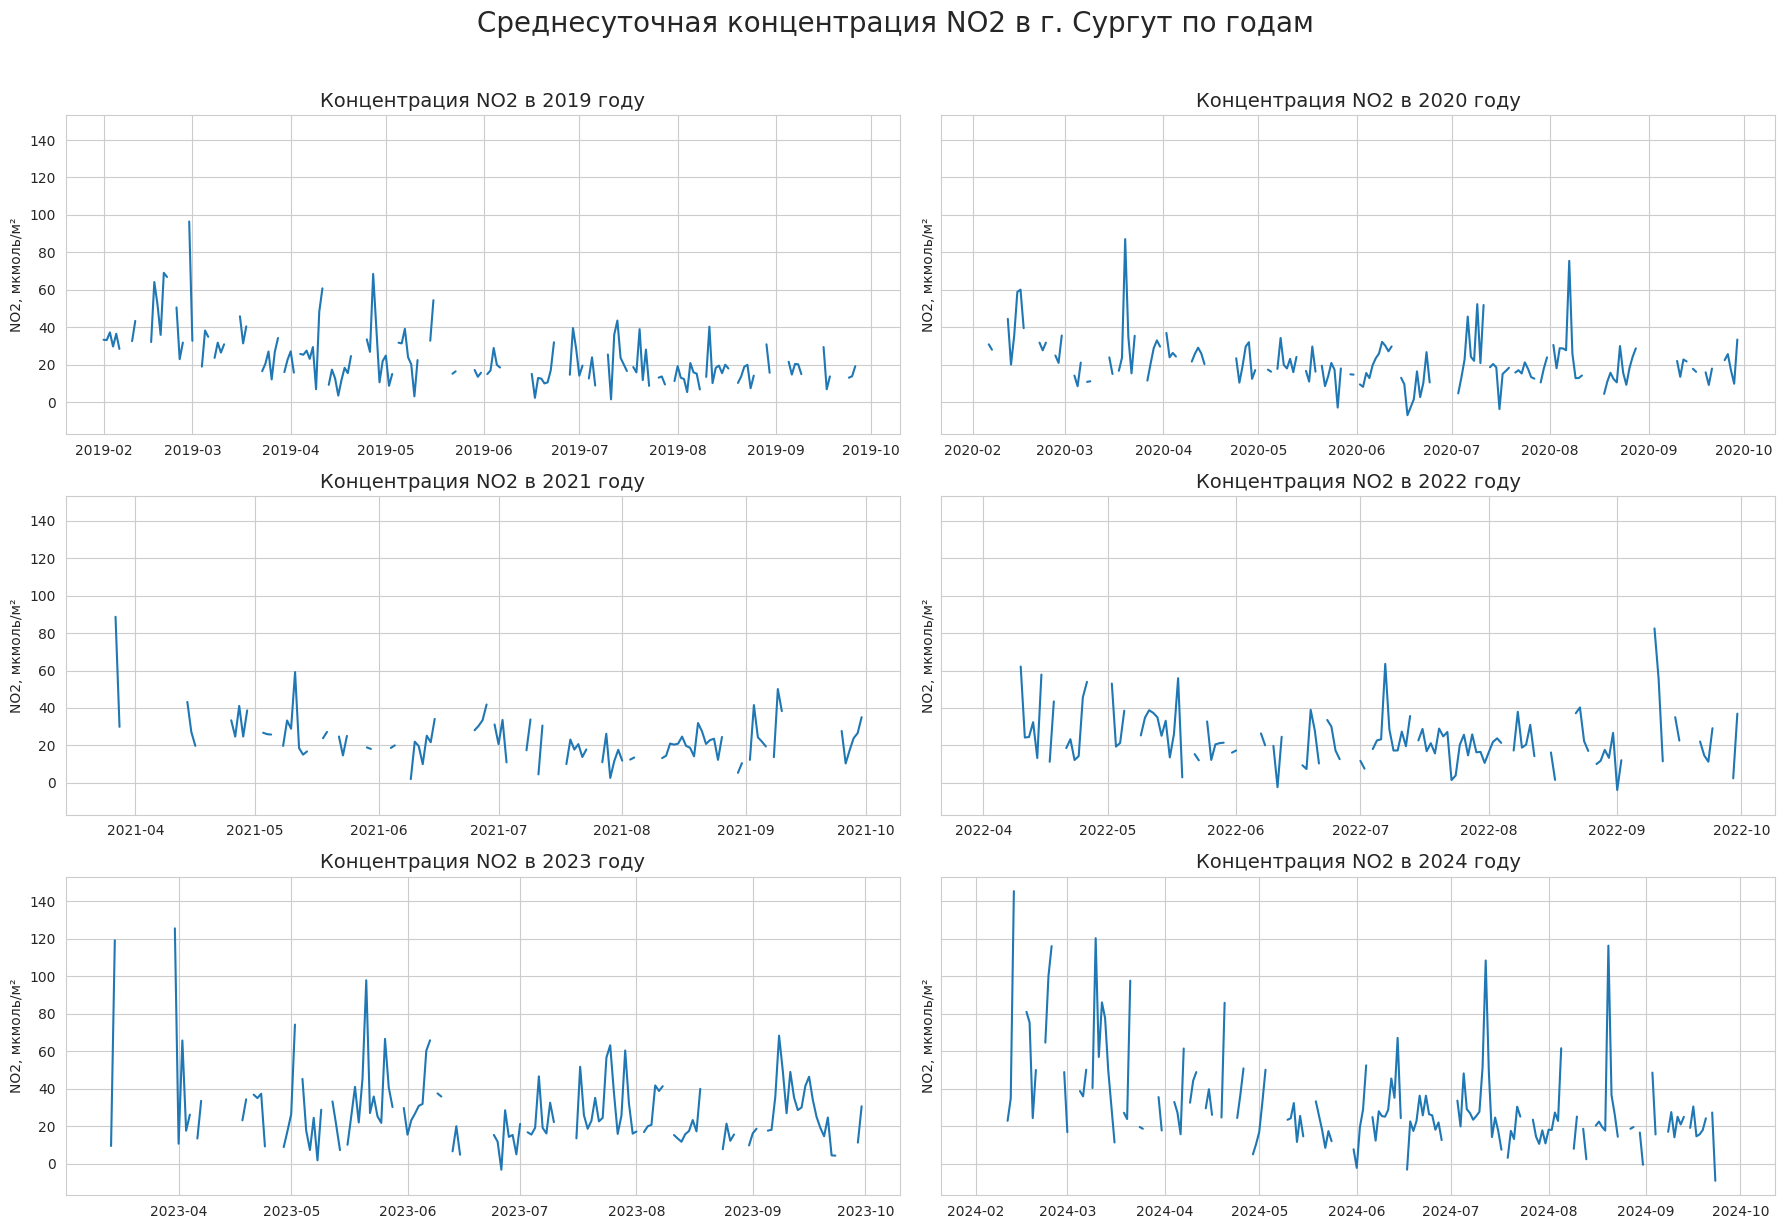

/tmp/ipython-input-1755028098.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='no2_umol_m2', data=df, palette='viridis')


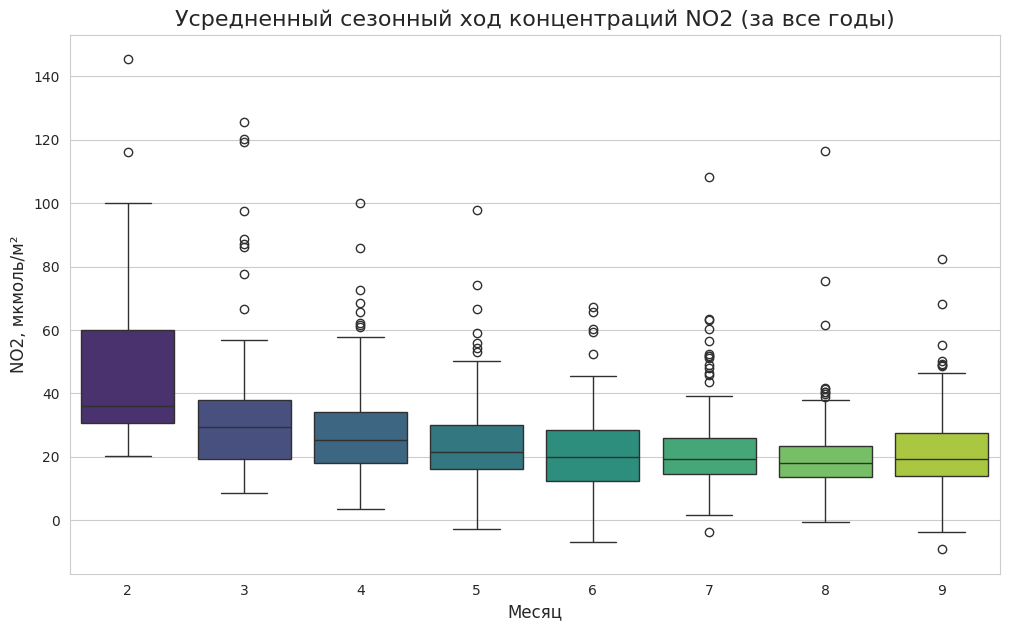

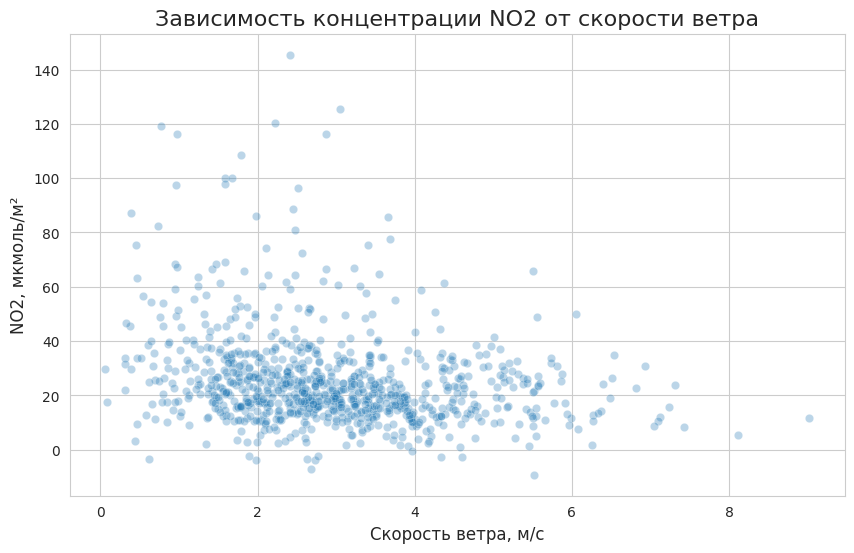

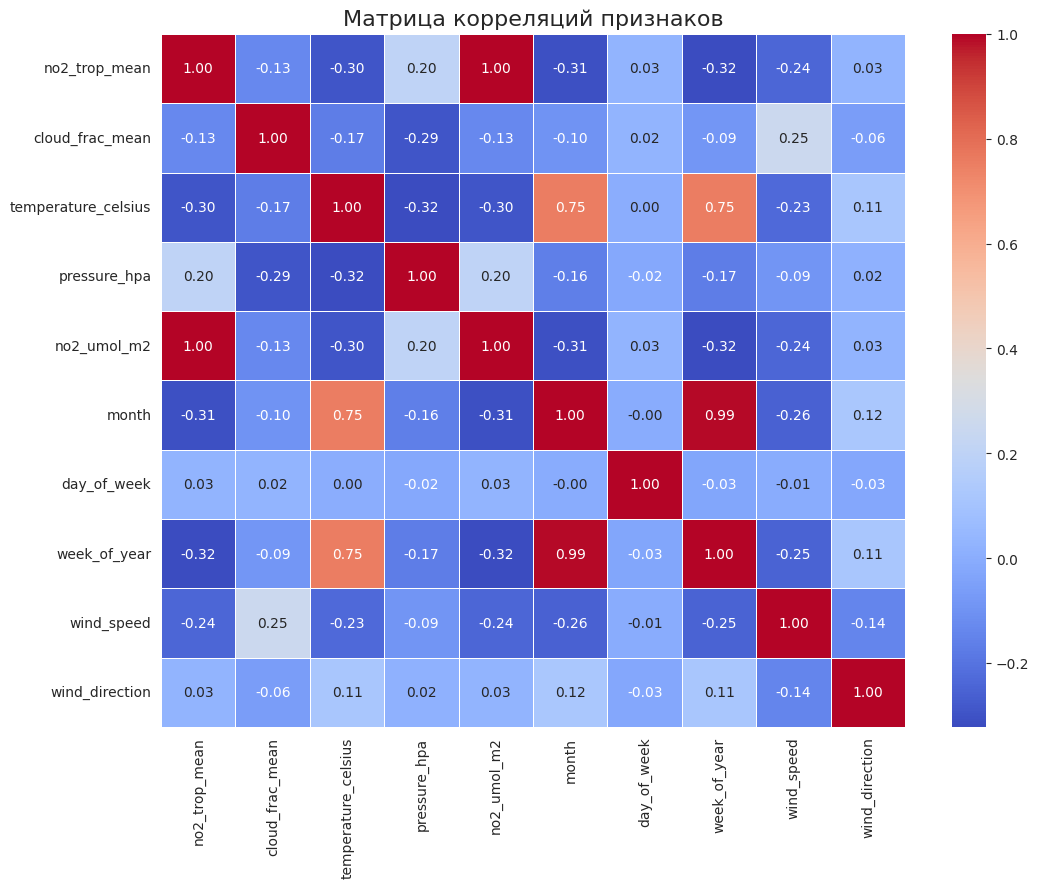

In [11]:
# --- 4. УЛУЧШЕННЫЙ ВИЗУАЛЬНЫЙ АНАЛИЗ (EDA) ---
sns.set_style("whitegrid")

# --- УЛУЧШЕННЫЙ ГРАФИК 1: Временной ряд по годам ---
years = df['year'].unique()
# Создаем сетку 3x2 для 6 лет
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharey=True)
axes = axes.flatten() # Превращаем матрицу осей в одномерный массив для удобства

for i, year in enumerate(years):
    ax = axes[i]
    data_year = df[df['year'] == year]
    ax.plot(data_year.index, data_year['no2_umol_m2'], label=f'Год {year}')
    ax.set_title(f'Концентрация NO2 в {year} году', fontsize=14)
    ax.set_ylabel('NO2, мкмоль/м²')
    ax.grid(True)

fig.suptitle('Среднесуточная концентрация NO2 в г. Сургут по годам', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


# --- ГРАФИК 2 (без изменений, теперь вы понимаете его смысл) ---
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='no2_umol_m2', data=df, palette='viridis')
plt.title('Усредненный сезонный ход концентраций NO2 (за все годы)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('NO2, мкмоль/м²', fontsize=12)
plt.show()

# --- ГРАФИК 3 (без изменений, подтверждает вашу гипотезу) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='wind_speed', y='no2_umol_m2', alpha=0.3)
plt.title('Зависимость концентрации NO2 от скорости ветра', fontsize=16)
plt.xlabel('Скорость ветра, м/с', fontsize=12)
plt.ylabel('NO2, мкмоль/м²', fontsize=12)
plt.show()

# --- УЛУЧШЕННЫЙ ГРАФИК 4: Матрица корреляций с новой колонкой NO2 ---
plt.figure(figsize=(12, 9))
numeric_cols = df.select_dtypes(include=np.number).drop(['year'], axis=1)
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Матрица корреляций признаков', fontsize=16)
plt.show()

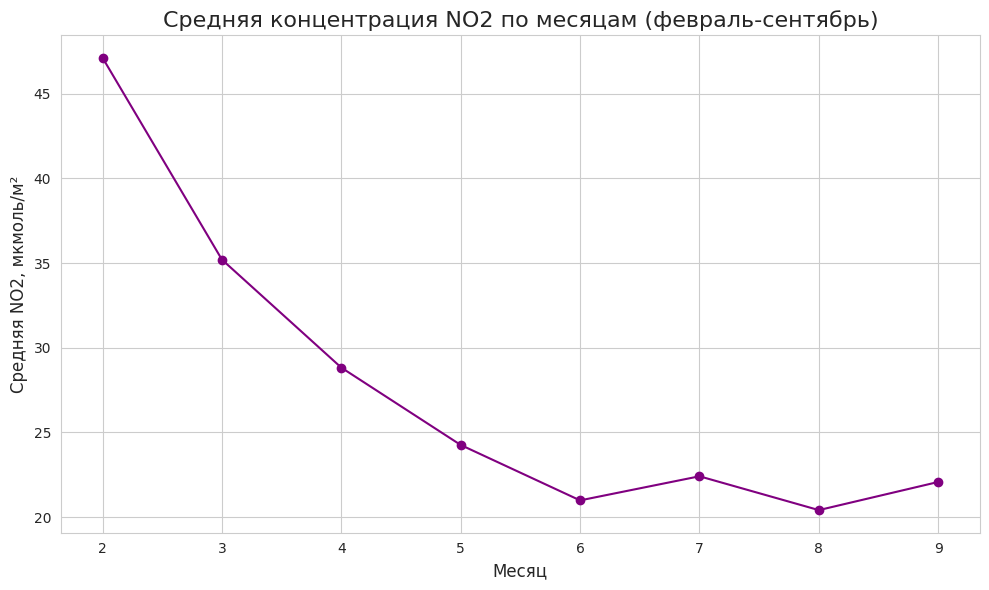

In [12]:
grouped_by_month = df.groupby('month')['no2_umol_m2'].mean()

# Фильтруем месяцы со 2 по 9
months_to_plot = grouped_by_month.loc[2:9]

plt.figure(figsize=(10, 6))
plt.plot(months_to_plot.index, months_to_plot.values, marker='o', linestyle='-', color='purple')
plt.title('Средняя концентрация NO2 по месяцам (февраль-сентябрь)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Средняя NO2, мкмоль/м²', fontsize=12)
plt.xticks(months_to_plot.index) # Убедимся, что все месяцы отображаются на оси X
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df.isna().sum()

,0
city,0
no2_trop_mean,577
cloud_frac_mean,7
temperature_celsius,0
pressure_hpa,0
no2_umol_m2,577
year,0
month,0
day_of_week,0
week_of_year,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1454 entries, 2019-02-01 to 2024-09-30
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 1454 non-null   object 
 1   no2_trop_mean        877 non-null    float64
 2   cloud_frac_mean      1447 non-null   float64
 3   temperature_celsius  1454 non-null   float64
 4   pressure_hpa         1454 non-null   float64
 5   no2_umol_m2          877 non-null    float64
 6   year                 1454 non-null   int32  
 7   month                1454 non-null   int32  
 8   day_of_week          1454 non-null   int32  
 9   week_of_year         1454 non-null   UInt32 
 10  wind_speed           1454 non-null   float64
 11  wind_direction       1454 non-null   float64
dtypes: UInt32(1), float64(7), int32(3), object(1)
memory usage: 126.4+ KB


/tmp/ipython-input-973437754.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=non_nan_counts_per_month.index, y=non_nan_counts_per_month.values, palette='viridis')


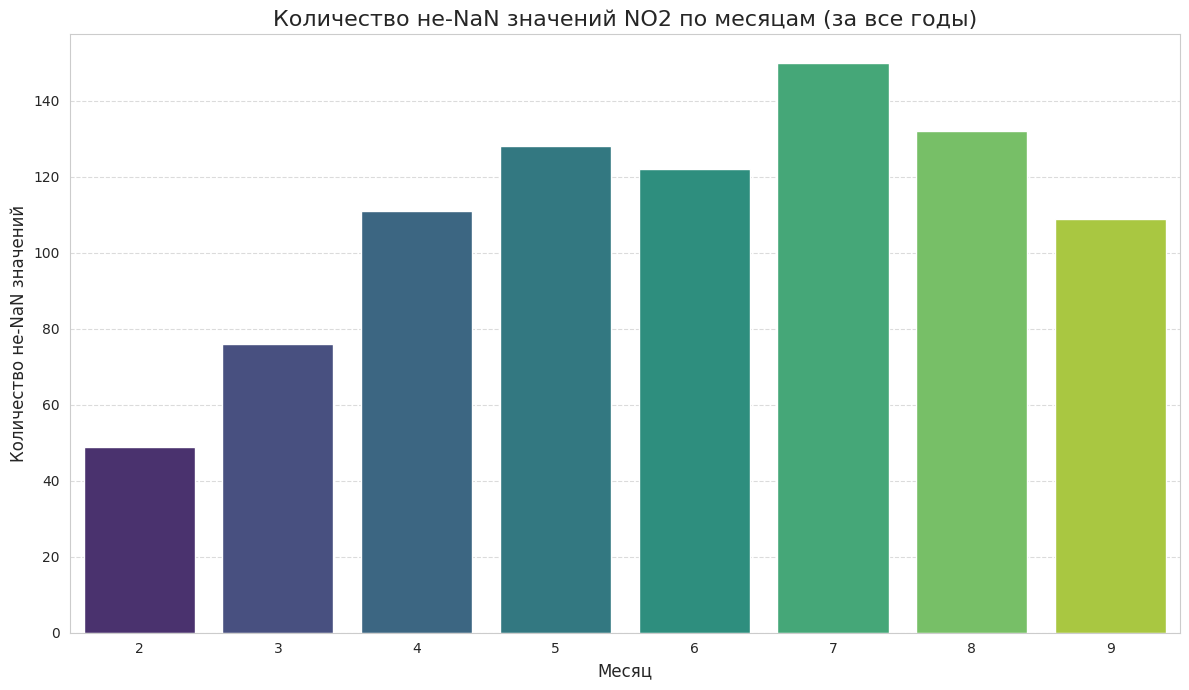

In [18]:


# Подсчитываем количество не-NaN значений no2_umol_m2 по месяцам
non_nan_counts_per_month = df.groupby('month')['no2_umol_m2'].count()

# Строим график
plt.figure(figsize=(12, 7))
sns.barplot(x=non_nan_counts_per_month.index, y=non_nan_counts_per_month.values, palette='viridis')
plt.title('Количество не-NaN значений NO2 по месяцам (за все годы)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество не-NaN значений', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1437068826.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_missing_per_month_per_year.index, y=average_missing_per_month_per_year.values, palette='plasma')


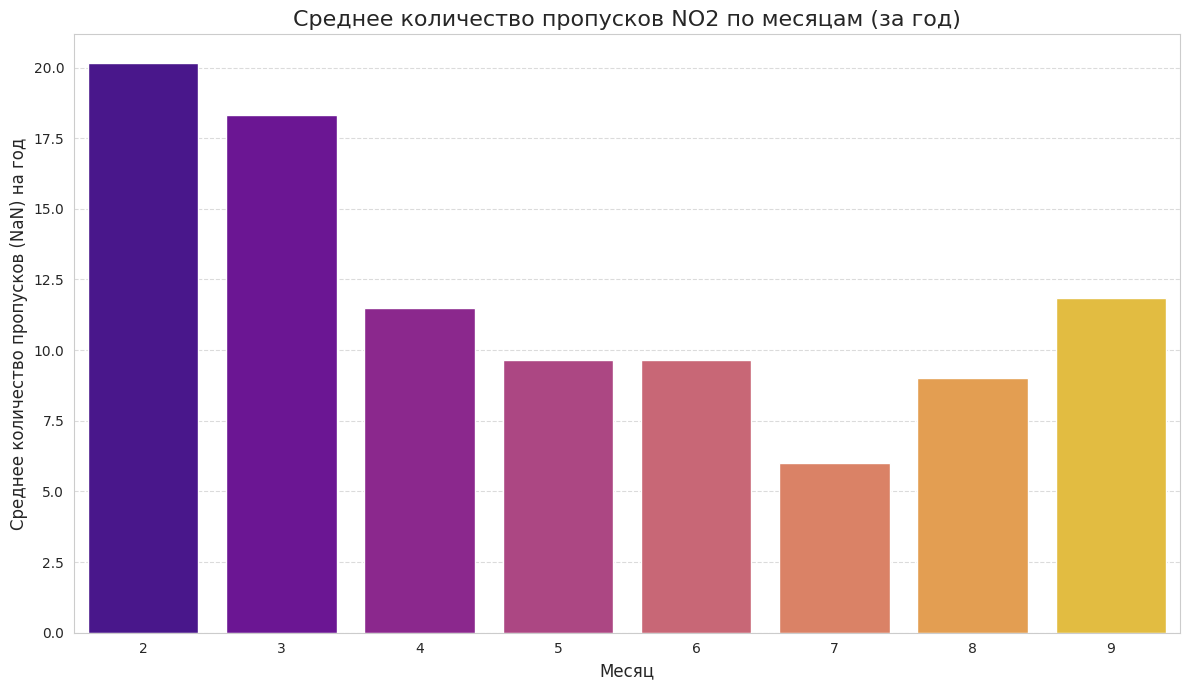


Среднее количество пропусков NO2 по месяцам (на год):
month
2    20.166667
3    18.333333
4    11.500000
5     9.666667
6     9.666667
7     6.000000
8     9.000000
9    11.833333
dtype: float64


In [19]:


# Подсчитываем количество NaN значений no2_umol_m2 по месяцам за все годы
missing_counts_per_month = df.groupby('month')['no2_umol_m2'].apply(lambda x: x.isnull().sum())

# Подсчитываем количество уникальных лет для каждого месяца, чтобы учесть количество данных
num_years_per_month = df.groupby('month')['year'].nunique()

# Рассчитываем среднее количество пропусков в месяц *за год*
# Используем .div() и .fillna(0) на случай, если num_years_per_month может быть 0 для какого-то месяца
average_missing_per_month_per_year = missing_counts_per_month.div(num_years_per_month).fillna(0)

# Строим график среднего количества пропусков
plt.figure(figsize=(12, 7))
sns.barplot(x=average_missing_per_month_per_year.index, y=average_missing_per_month_per_year.values, palette='plasma')
plt.title('Среднее количество пропусков NO2 по месяцам (за год)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Среднее количество пропусков (NaN) на год', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nСреднее количество пропусков NO2 по месяцам (на год):")
print(average_missing_per_month_per_year)

In [23]:
# Подсчитываем общее количество пропусков для каждого месяца
total_nan_per_month = df.groupby('month')['no2_umol_m2'].apply(lambda x: x.isnull().sum())

# Подсчитываем общее количество записей для каждого месяца
total_entries_per_month = df.groupby('month').size()

# Выбираем данные только для 2, 3, 4 месяцев
selected_months = [2, 3, 4]
nan_counts_selected = total_nan_per_month.loc[selected_months]
entries_counts_selected = total_entries_per_month.loc[selected_months]

# Суммируем количество пропусков и общее количество записей для выбранных месяцев
total_nans_combined = nan_counts_selected.sum()
total_entries_combined = entries_counts_selected.sum()

# Рассчитываем общую долю пропусков
overall_proportion_of_nans = total_nans_combined / total_entries_combined

print(f"Общая доля пропусков (NaN) по колонке 'no2_umol_m2' для 2, 3, 4 месяцев (в сумме): {overall_proportion_of_nans:.2%}")

Общая доля пропусков (NaN) по колонке 'no2_umol_m2' для 2, 3, 4 месяцев (в сумме): 55.97%


# Работа с аномалиями

In [ ]:
no2_feb_april = df.loc['2021-02':'2021-04', 'no2_umol_m2']
no2_feb_april.head(30)

,no2_umol_m2
date,
2021-02-01,38.361659
2021-02-02,38.400879
2021-02-03,38.440100
2021-02-04,38.479320
2021-02-05,38.518540
2021-02-06,38.557760
2021-02-07,38.596980
2021-02-08,38.636200
2021-02-09,38.675420


In [ ]:
display(no2_feb_april)

,no2_umol_m2
date,
2021-02-01,38.361659
2021-02-02,38.400879
2021-02-03,38.440100
2021-02-04,38.479320
2021-02-05,38.518540
...,...
2021-04-26,24.697449
2021-04-27,41.099060
2021-04-28,24.743640


In [ ]:
pd.set_option('display.max_rows', None) # Устанавливаем опцию для отображения всех строк
display(no2_feb_april)
pd.reset_option('display.max_rows') # Сбрасываем опцию до значения по умолчанию после вывода

,no2_umol_m2
date,
2021-02-01,38.361659
2021-02-02,38.400879
2021-02-03,38.440100
2021-02-04,38.479320
2021-02-05,38.518540
2021-02-06,38.557760
2021-02-07,38.596980
2021-02-08,38.636200
2021-02-09,38.675420


In [ ]:
# Выгружаем Series no2_feb_april в CSV файл
no2_feb_april.to_csv('no2_feb_april.csv')
print("Данные из 'no2_feb_april' успешно сохранены в файл 'no2_feb_april.csv'")

Данные из 'no2_feb_april' успешно сохранены в файл 'no2_feb_april.csv'


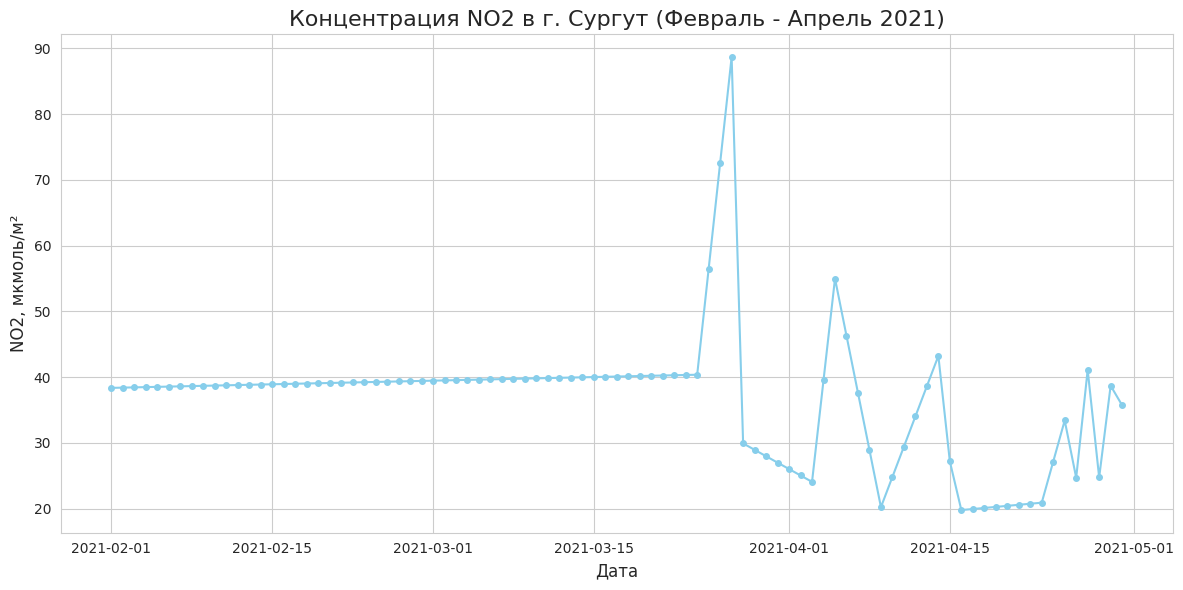

In [ ]:
# Фильтруем данные за нужный период
data_to_plot = df.loc['2021-02':'2021-04', 'no2_umol_m2']

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(data_to_plot.index, data_to_plot.values, marker='o', linestyle='-', markersize=4, color='skyblue')
plt.title('Концентрация NO2 в г. Сургут (Февраль - Апрель 2021)', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('NO2, мкмоль/м²', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Максимальные и минимальные значения NO2 по месяцам за каждый год ---")
monthly_min_max = df.groupby(['year', 'month'])['no2_umol_m2'].agg(['min', 'max'])
print(monthly_min_max)

print("\n--- Максимальные и минимальные значения NO2 за каждый год ---")
yearly_min_max = df.groupby('year')['no2_umol_m2'].agg(['min', 'max'])
print(yearly_min_max)


--- Максимальные и минимальные значения NO2 по месяцам за каждый год ---
                  min         max
year month                       
2019 2      22.994372   96.495602
     3      12.169221   66.455193
     4       3.526874   68.487383
     5       3.124751   54.454530
     6       2.346958   59.246399
     7       1.538761   43.591496
     8       5.392438   40.327205
     9       5.573956   33.849877
2020 2      20.081681   60.098729
     3       8.535314   87.095308
     4      10.448530   36.972509
     5      -2.848789   34.298463
     6      -6.930164   32.212945
     7      -3.667760   52.361814
     8       4.439263   75.460444
     9       5.552222   33.498366
2021 2      38.361659   39.420602
     3      26.994161   88.682311
     4      19.780763   54.982101
     5      10.900197   59.177749
     6       1.975240   41.833262
     7       2.668172   33.862599
     8       5.363883   34.205481
     9       1.142426   50.091550
2022 2      29.217479   30.265188
     3  

In [ ]:
monthly_min_max.to_csv('monthly_min_max')

In [ ]:
yearly_min_max.to_csv('year_min_max')